<a href="https://colab.research.google.com/github/nirb28/llm/blob/main/demoes/llm-book/inference/tensorrt_triton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inference with TensorRT**

## YOLO-V5

In [1]:
!pip install opencv-python
!pip install numpy
!pip install torch-tensorrt
!pip install pandas
!pip install matplotlib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/

In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Use GPU for inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
# Download COCO validation data set
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip

--2024-02-28 13:45:22--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.43.217, 3.5.30.157, 52.216.208.41, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.43.217|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip.3’

val2017.zip.3         0%[                    ]   2.30M  1.54MB/s               ^C
replace val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# Iterate through the images in the dataset
import os
import cv2

def prepare_images(image_paths):

    images = []
    for image_path in image_paths:
      image = cv2.imread(image_path)

      # Preprocess the image
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (640, 640))

      image = image.transpose((2, 0, 1)) # W, H, C => C, H, W
      image = torch.from_numpy(image).to(device)
      image = image.float() / 255.0 # Normalize [0;1]
      images.append(image)

    return images

In [ ]:
# Load COCO dataset
image_dir = 'val2017'
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]

# Only take a subset of COCO
IMAGE_NUMS = 128
images = prepare_images(image_paths[:IMAGE_NUMS])

In [ ]:
import time

def run_inference(model, images):
  times = []
  results = []
  for image in images:
    # Move image to GPU, if not already
    image = image.unsqueeze(0)
    image_gpu = image.to('cuda')

    # Run inference with no gradient calculation
    start = time.time()
    with torch.no_grad():
        result = model(image_gpu)

    results.append(result)
    times.append(time.time() - start)

  return results, times

In [ ]:
NUM_TRIALS = 10
avgs = []

for i in range(NUM_TRIALS):
    results, times = run_inference(model, images)
    avg = sum(times)/len(times)
    print("Average inference time (s):", avg)
    avgs.append(avg)

mat = sum(avgs)/NUM_TRIALS
print("Mean average inference time (s):", mat)

Average inference time (s): 0.008198220282793045
Average inference time (s): 0.006218124181032181
Average inference time (s): 0.007922634482383728
Average inference time (s): 0.008371112868189812
Average inference time (s): 0.007605014368891716
Average inference time (s): 0.005643885582685471
Average inference time (s): 0.0056277308613061905
Average inference time (s): 0.005955127999186516
Average inference time (s): 0.010654594749212265
Average inference time (s): 0.010228211060166359
Mean average inference time (s): 0.007642465643584728


# **Accelerating the model with TensorRT**

In [ ]:
import torch_tensorrt

model.eval()  # Set the model to evaluation mode
input_data = torch.randn(1, 3, 640, 640)


trt_model = torch_tensorrt.compile(model, inputs=[input_data],
                                   ir='ts',
                                   enabled_precisions={torch.float32},
                                   truncate_long_and_double=True)

/home/long/.cache/torch/hub/ultralytics_yolov5_master/models/yolo.py:100: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:
/home/long/.cache/torch/hub/ultralytics_yolov5_master/models/yolo.py:100: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:


In [ ]:
print("TensorRT optimized")

avgs = []
for i in range(NUM_TRIALS):
    trt_results, trt_time = run_inference(trt_model, images)
    avg = sum(trt_time)/len(images)
    print("Average inference time (s):", avg)
    avgs.append(avg)

trt_mat = sum(avgs)/NUM_TRIALS
print("Mean average inference time (s):", trt_mat)

TensorRT optimized
Average inference time (s): 0.004738861694931984
Average inference time (s): 0.003201013430953026
Average inference time (s): 0.0034089460968971252
Average inference time (s): 0.003065887838602066
Average inference time (s): 0.002827117219567299
Average inference time (s): 0.0027531571686267853
Average inference time (s): 0.0029252376407384872
Average inference time (s): 0.002684958279132843
Average inference time (s): 0.0024376586079597473
Average inference time (s): 0.0030416101217269897
Mean average inference time (s): 0.0031084448099136354


In [ ]:
speed_up = mat / trt_mat
print("Speed up:", speed_up)

Speed up: 2.4586139085406717


# **Batching**

In [ ]:
import torch_tensorrt
import torch

# Example for dynamic batch size
BATCH_SIZE = 16
DYNAMIC_BATCH_ENABLED = True
input_data = torch.randn(BATCH_SIZE, 3, 640, 640)

if DYNAMIC_BATCH_ENABLED:
    # Specify dynamic batch size
    inputs = [torch_tensorrt.Input(
        min_shape=[1, 3, 640, 640],
        opt_shape=[BATCH_SIZE, 3, 640, 640],
        max_shape=[32, 3, 640, 640],  # Example max batch size
        dtype=torch.float32  # Ensure this matches your model's expected input type
    )]
else:
    inputs = [input_data]

ts = torch.jit.trace(model, input_data, strict=False)
trt_model = torch_tensorrt.compile(ts,
                                   inputs=inputs,
                                   enabled_precisions={torch.float32},
                                   truncate_long_and_double=True)

/home/long/.cache/torch/hub/ultralytics_yolov5_master/models/yolo.py:100: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:
/home/long/.cache/torch/hub/ultralytics_yolov5_master/models/yolo.py:100: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:


In [ ]:
def run_inference_in_batches(model, images, batch_size=BATCH_SIZE):
    times = []
    results = []

    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]

        # Stack images to create a batch
        batch = torch.stack(batch_images).to('cuda')

        start = time.time()
        with torch.no_grad():
            result = model(batch)

        results.append(result)
        times.append(time.time() - start)

    return results, times

In [ ]:
print("TensorRT optimized - Batched ", BATCH_SIZE)
avgs = []
for i in range(NUM_TRIALS):
    batched_results, batched_time = run_inference_in_batches(trt_model, images)
    avg = sum(batched_time)/len(images)
    print("Average inference time (s):", avg)
    avgs.append(avg)

batched_mat = sum(avgs)/NUM_TRIALS
print("Mean average inference time (s):", batched_mat)

TensorRT optimized - Batched  16
Average inference time (s): 0.0031599905341863632
Average inference time (s): 0.0016660261899232864
Average inference time (s): 0.0016808975487947464
Average inference time (s): 0.0016959533095359802
Average inference time (s): 0.0017578788101673126
Average inference time (s): 0.00174027681350708
Average inference time (s): 0.00173121877014637
Average inference time (s): 0.0017148610204458237
Average inference time (s): 0.0016897749155759811
Average inference time (s): 0.0017396770417690277
Mean average inference time (s): 0.001857655495405197


In [ ]:
mat/batched_mat

4.114038185491294

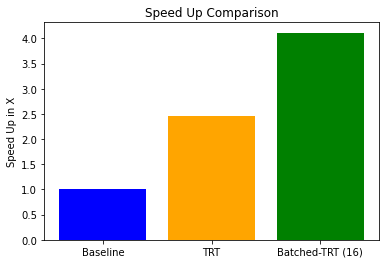

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

speed_up_values = [mat / mat, mat / trt_mat, mat / batched_mat]
labels = ['Baseline', 'TRT', 'Batched-TRT (16)']

plt.bar(labels, speed_up_values, color=['blue', 'orange', 'green'])

# Adding labels and title
plt.ylabel('Speed Up in X')
plt.title('Speed Up Comparison')

# Display the plot
plt.show()